In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pairs = [('NEM','NVDA'), ('NEM','MSFT'), ('NEM','AAPL'), ('RCL','NVDA'), ('RCL','MSFT'), ('RCL','AAPL'), ('MSI','NVDA'), ('MSI','MSFT'), ('MSI','AAPL')] # closing

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_40478/1896124326.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_40478/1896124326.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  6 of 6 completed


In [4]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(spread, lower, upper):
    z = rolling_zscore(spread)
    labels = ((z <= lower) | (z >= upper)).astype(int)
    return labels

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = rolling_zscore(df['spread'])

    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

window = 5

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    test_spread_mean = training_spread.mean()
    test_spread_std = training_spread.std()

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, lower = -1, upper = 1)

    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, lower = -1, upper = 1)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [5]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [6]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out.squeeze()

In [7]:
def train_model(model, train_loader, criterion, optimizer, epochs = 30, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [8]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.7).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy: ", accuracy)
    return y_true, y_pred, y_pred_label

In [9]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x = aligned_spread.index, y = aligned_spread.values, label = 'Spread', color = 'black')
    sns.scatterplot(x = predicted_points.index, y = predicted_points.values, color = 'green', label = 'Predicted Reversion', s = 100, marker = 'o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [11]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [12]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device = 'cpu'):

    hidden_size = 70
    lr = 0.001
    num_layers = 2
    window_size = 5
    batch_size = 32

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype = torch.float32)
    y_train = torch.tensor(y_seq, dtype = torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    # criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    criterion = nn.BCEWithLogitsLoss()

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype = torch.float32)
    y_test = torch.tensor(y_test_seq, dtype = torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred


Training model for pair: NEM_NVDA
Epoch 1/50 - Loss: 0.6571
Epoch 2/50 - Loss: 0.5532
Epoch 3/50 - Loss: 0.4884
Epoch 4/50 - Loss: 0.4577
Epoch 5/50 - Loss: 0.4383
Epoch 6/50 - Loss: 0.4214
Epoch 7/50 - Loss: 0.3932
Epoch 8/50 - Loss: 0.3832
Epoch 9/50 - Loss: 0.3762
Epoch 10/50 - Loss: 0.3634
Epoch 11/50 - Loss: 0.3504
Epoch 12/50 - Loss: 0.3536
Epoch 13/50 - Loss: 0.3416
Epoch 14/50 - Loss: 0.3295
Epoch 15/50 - Loss: 0.3226
Epoch 16/50 - Loss: 0.3319
Epoch 17/50 - Loss: 0.3131
Epoch 18/50 - Loss: 0.3161
Epoch 19/50 - Loss: 0.3104
Epoch 20/50 - Loss: 0.3045
Epoch 21/50 - Loss: 0.3038
Epoch 22/50 - Loss: 0.3103
Epoch 23/50 - Loss: 0.3116
Epoch 24/50 - Loss: 0.3071
Epoch 25/50 - Loss: 0.3178
Epoch 26/50 - Loss: 0.2945
Epoch 27/50 - Loss: 0.2965
Epoch 28/50 - Loss: 0.2907
Epoch 29/50 - Loss: 0.2939
Epoch 30/50 - Loss: 0.2869
Epoch 31/50 - Loss: 0.2835
Epoch 32/50 - Loss: 0.2799
Epoch 33/50 - Loss: 0.2841
Epoch 34/50 - Loss: 0.2744
Epoch 35/50 - Loss: 0.2680
Epoch 36/50 - Loss: 0.2654
Ep

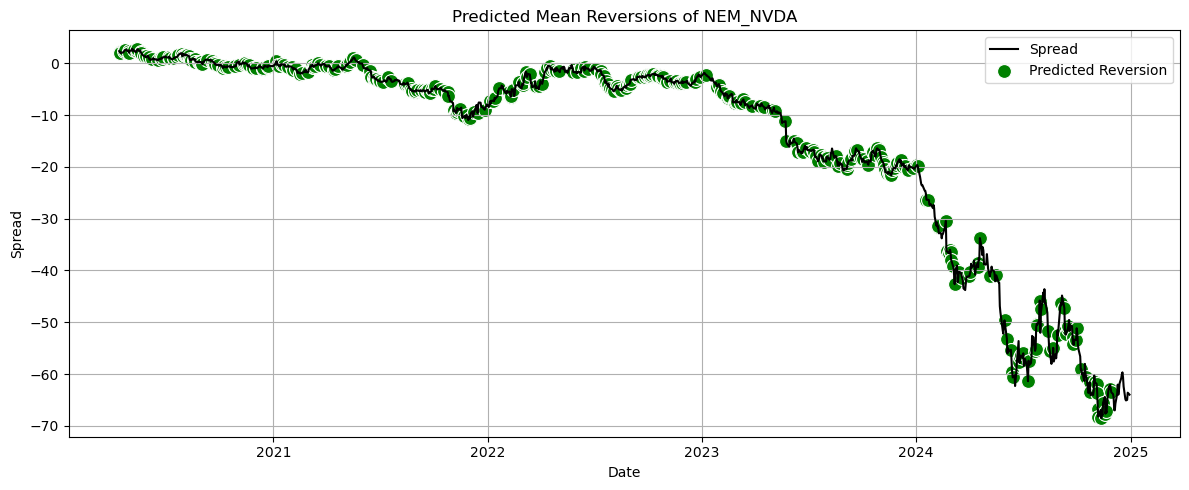

Confusion Matrix:
[[492  21]
 [325 350]]
F1 Score: 0.6692

Training model for pair: NEM_MSFT
Epoch 1/50 - Loss: 0.6581
Epoch 2/50 - Loss: 0.5717
Epoch 3/50 - Loss: 0.5252
Epoch 4/50 - Loss: 0.5106
Epoch 5/50 - Loss: 0.4876
Epoch 6/50 - Loss: 0.4766
Epoch 7/50 - Loss: 0.4648
Epoch 8/50 - Loss: 0.4454
Epoch 9/50 - Loss: 0.4271
Epoch 10/50 - Loss: 0.4191
Epoch 11/50 - Loss: 0.4031
Epoch 12/50 - Loss: 0.3886
Epoch 13/50 - Loss: 0.3892
Epoch 14/50 - Loss: 0.3751
Epoch 15/50 - Loss: 0.3737
Epoch 16/50 - Loss: 0.3547
Epoch 17/50 - Loss: 0.3545
Epoch 18/50 - Loss: 0.3531
Epoch 19/50 - Loss: 0.3595
Epoch 20/50 - Loss: 0.3726
Epoch 21/50 - Loss: 0.3465
Epoch 22/50 - Loss: 0.3510
Epoch 23/50 - Loss: 0.3407
Epoch 24/50 - Loss: 0.3419
Epoch 25/50 - Loss: 0.3449
Epoch 26/50 - Loss: 0.3373
Epoch 27/50 - Loss: 0.3480
Epoch 28/50 - Loss: 0.3435
Epoch 29/50 - Loss: 0.3415
Epoch 30/50 - Loss: 0.3412
Epoch 31/50 - Loss: 0.3376
Epoch 32/50 - Loss: 0.3288
Epoch 33/50 - Loss: 0.3384
Epoch 34/50 - Loss: 0.330

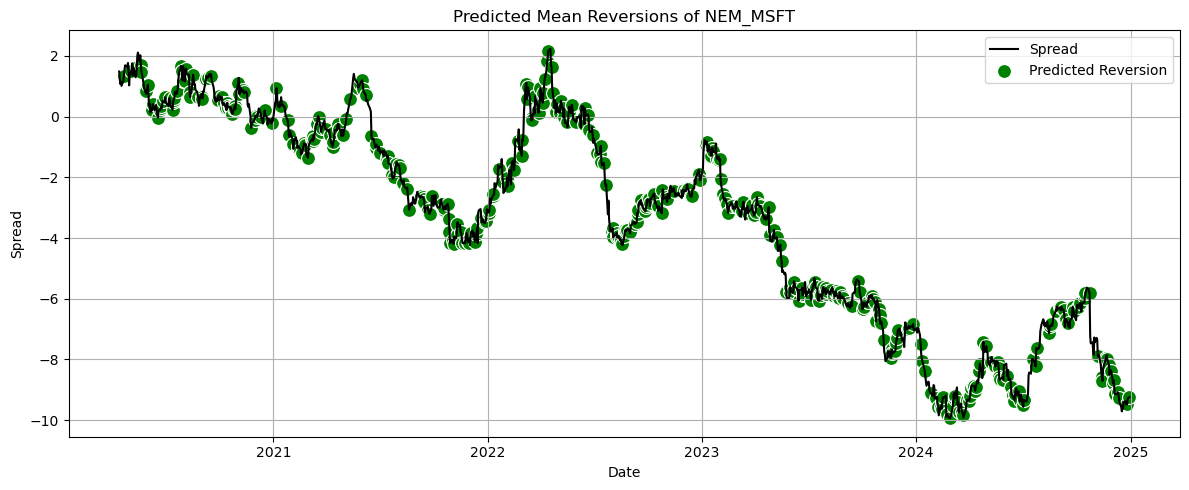

Confusion Matrix:
[[419  34]
 [339 396]]
F1 Score: 0.6798

Training model for pair: NEM_AAPL
Epoch 1/50 - Loss: 0.6583
Epoch 2/50 - Loss: 0.5757
Epoch 3/50 - Loss: 0.5080
Epoch 4/50 - Loss: 0.4744
Epoch 5/50 - Loss: 0.4722
Epoch 6/50 - Loss: 0.4422
Epoch 7/50 - Loss: 0.4250
Epoch 8/50 - Loss: 0.4096
Epoch 9/50 - Loss: 0.3943
Epoch 10/50 - Loss: 0.4010
Epoch 11/50 - Loss: 0.3826
Epoch 12/50 - Loss: 0.3782
Epoch 13/50 - Loss: 0.3611
Epoch 14/50 - Loss: 0.3542
Epoch 15/50 - Loss: 0.3508
Epoch 16/50 - Loss: 0.3352
Epoch 17/50 - Loss: 0.3412
Epoch 18/50 - Loss: 0.3285
Epoch 19/50 - Loss: 0.3299
Epoch 20/50 - Loss: 0.3174
Epoch 21/50 - Loss: 0.3149
Epoch 22/50 - Loss: 0.3173
Epoch 23/50 - Loss: 0.3079
Epoch 24/50 - Loss: 0.3085
Epoch 25/50 - Loss: 0.2992
Epoch 26/50 - Loss: 0.3061
Epoch 27/50 - Loss: 0.2898
Epoch 28/50 - Loss: 0.3216
Epoch 29/50 - Loss: 0.2868
Epoch 30/50 - Loss: 0.2903
Epoch 31/50 - Loss: 0.2807
Epoch 32/50 - Loss: 0.2838
Epoch 33/50 - Loss: 0.2748
Epoch 34/50 - Loss: 0.274

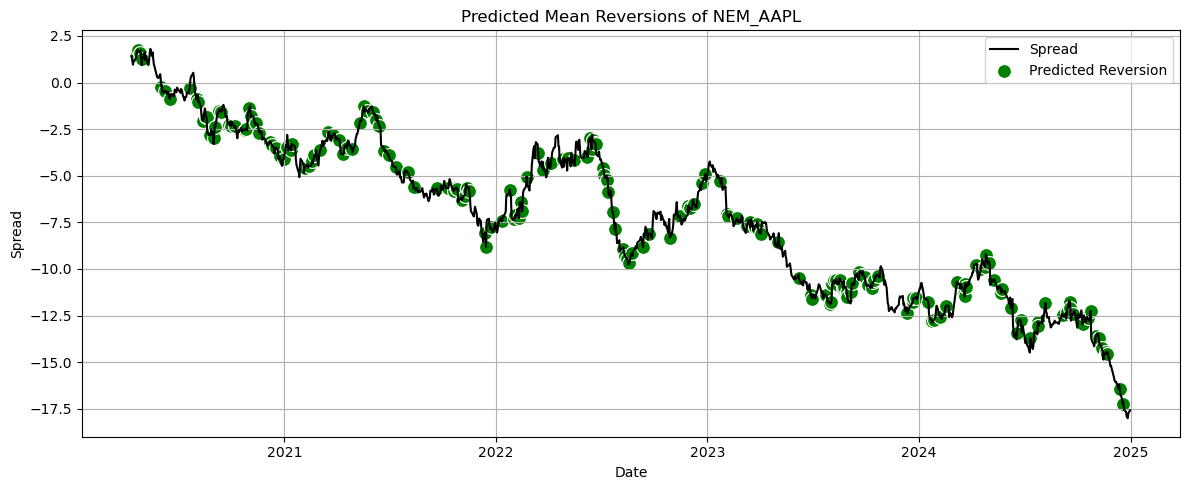

Confusion Matrix:
[[473  11]
 [522 182]]
F1 Score: 0.4058

Training model for pair: RCL_NVDA
Epoch 1/50 - Loss: 0.6784
Epoch 2/50 - Loss: 0.5871
Epoch 3/50 - Loss: 0.5605
Epoch 4/50 - Loss: 0.5251
Epoch 5/50 - Loss: 0.5123
Epoch 6/50 - Loss: 0.4823
Epoch 7/50 - Loss: 0.4657
Epoch 8/50 - Loss: 0.4444
Epoch 9/50 - Loss: 0.4255
Epoch 10/50 - Loss: 0.4195
Epoch 11/50 - Loss: 0.4142
Epoch 12/50 - Loss: 0.3844
Epoch 13/50 - Loss: 0.3717
Epoch 14/50 - Loss: 0.3820
Epoch 15/50 - Loss: 0.3609
Epoch 16/50 - Loss: 0.3605
Epoch 17/50 - Loss: 0.3780
Epoch 18/50 - Loss: 0.3647
Epoch 19/50 - Loss: 0.3545
Epoch 20/50 - Loss: 0.3556
Epoch 21/50 - Loss: 0.3423
Epoch 22/50 - Loss: 0.3455
Epoch 23/50 - Loss: 0.3419
Epoch 24/50 - Loss: 0.3372
Epoch 25/50 - Loss: 0.3417
Epoch 26/50 - Loss: 0.3527
Epoch 27/50 - Loss: 0.3391
Epoch 28/50 - Loss: 0.3301
Epoch 29/50 - Loss: 0.3285
Epoch 30/50 - Loss: 0.3301
Epoch 31/50 - Loss: 0.3392
Epoch 32/50 - Loss: 0.3296
Epoch 33/50 - Loss: 0.3174
Epoch 34/50 - Loss: 0.323

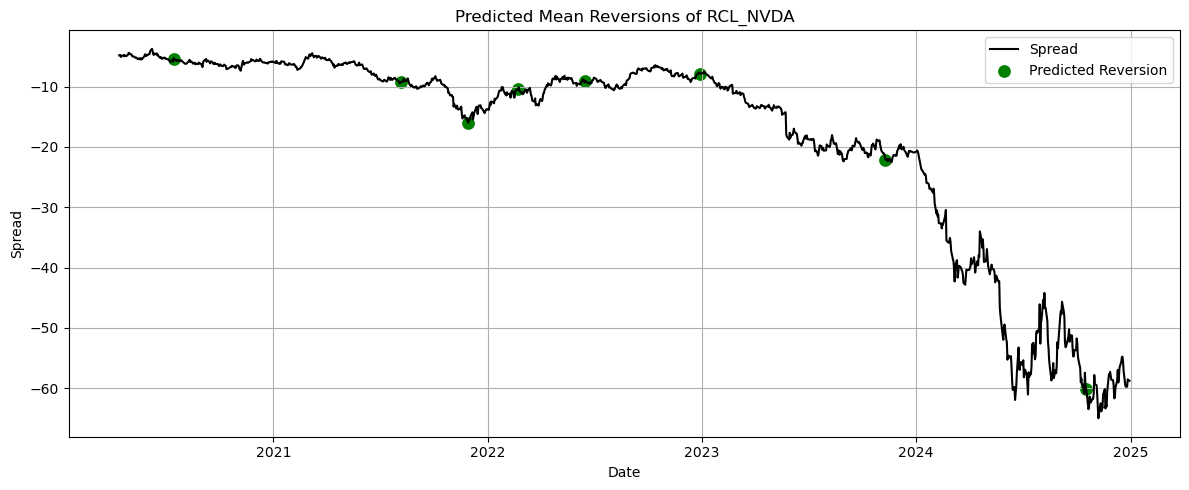

Confusion Matrix:
[[491   1]
 [689   7]]
F1 Score: 0.0199

Training model for pair: RCL_MSFT
Epoch 1/50 - Loss: 0.6721
Epoch 2/50 - Loss: 0.5800
Epoch 3/50 - Loss: 0.5254
Epoch 4/50 - Loss: 0.5037
Epoch 5/50 - Loss: 0.4819
Epoch 6/50 - Loss: 0.4642
Epoch 7/50 - Loss: 0.4457
Epoch 8/50 - Loss: 0.4266
Epoch 9/50 - Loss: 0.4371
Epoch 10/50 - Loss: 0.4023
Epoch 11/50 - Loss: 0.3843
Epoch 12/50 - Loss: 0.3821
Epoch 13/50 - Loss: 0.3626
Epoch 14/50 - Loss: 0.3599
Epoch 15/50 - Loss: 0.3446
Epoch 16/50 - Loss: 0.3587
Epoch 17/50 - Loss: 0.3431
Epoch 18/50 - Loss: 0.3348
Epoch 19/50 - Loss: 0.3373
Epoch 20/50 - Loss: 0.3314
Epoch 21/50 - Loss: 0.3321
Epoch 22/50 - Loss: 0.3412
Epoch 23/50 - Loss: 0.3286
Epoch 24/50 - Loss: 0.3220
Epoch 25/50 - Loss: 0.3240
Epoch 26/50 - Loss: 0.3306
Epoch 27/50 - Loss: 0.3301
Epoch 28/50 - Loss: 0.3572
Epoch 29/50 - Loss: 0.3321
Epoch 30/50 - Loss: 0.3391
Epoch 31/50 - Loss: 0.3120
Epoch 32/50 - Loss: 0.3197
Epoch 33/50 - Loss: 0.3166
Epoch 34/50 - Loss: 0.308

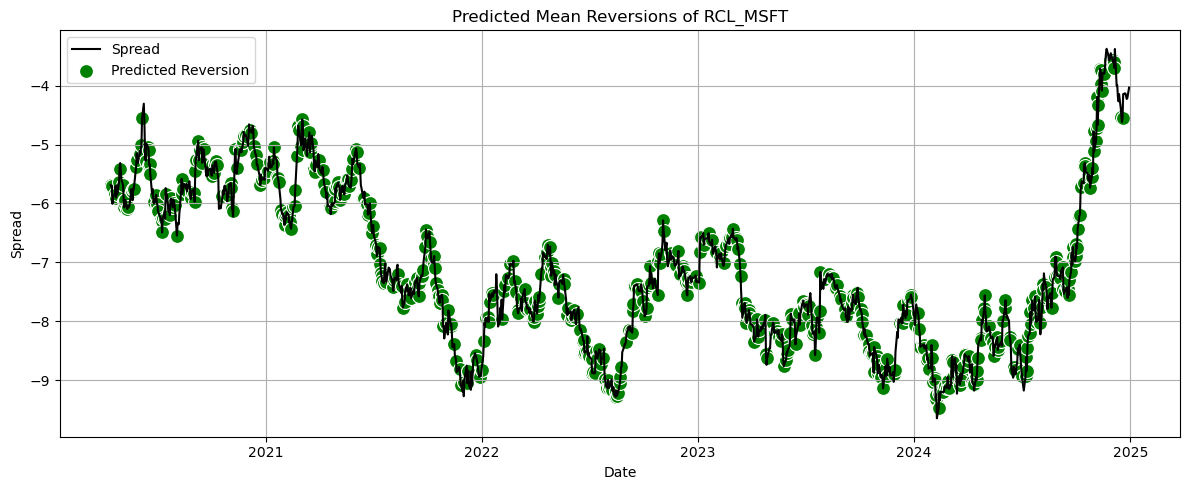

Confusion Matrix:
[[323 231]
 [210 424]]
F1 Score: 0.6579

Training model for pair: RCL_AAPL
Epoch 1/50 - Loss: 0.6792
Epoch 2/50 - Loss: 0.5984
Epoch 3/50 - Loss: 0.5520
Epoch 4/50 - Loss: 0.5108
Epoch 5/50 - Loss: 0.4935
Epoch 6/50 - Loss: 0.4774
Epoch 7/50 - Loss: 0.4445
Epoch 8/50 - Loss: 0.4261
Epoch 9/50 - Loss: 0.4257
Epoch 10/50 - Loss: 0.4036
Epoch 11/50 - Loss: 0.3908
Epoch 12/50 - Loss: 0.3838
Epoch 13/50 - Loss: 0.3595
Epoch 14/50 - Loss: 0.3467
Epoch 15/50 - Loss: 0.3501
Epoch 16/50 - Loss: 0.3422
Epoch 17/50 - Loss: 0.3377
Epoch 18/50 - Loss: 0.3313
Epoch 19/50 - Loss: 0.3353
Epoch 20/50 - Loss: 0.3418
Epoch 21/50 - Loss: 0.3282
Epoch 22/50 - Loss: 0.3157
Epoch 23/50 - Loss: 0.3120
Epoch 24/50 - Loss: 0.3098
Epoch 25/50 - Loss: 0.3375
Epoch 26/50 - Loss: 0.3167
Epoch 27/50 - Loss: 0.3028
Epoch 28/50 - Loss: 0.3007
Epoch 29/50 - Loss: 0.3003
Epoch 30/50 - Loss: 0.2913
Epoch 31/50 - Loss: 0.2829
Epoch 32/50 - Loss: 0.2845
Epoch 33/50 - Loss: 0.2852
Epoch 34/50 - Loss: 0.282

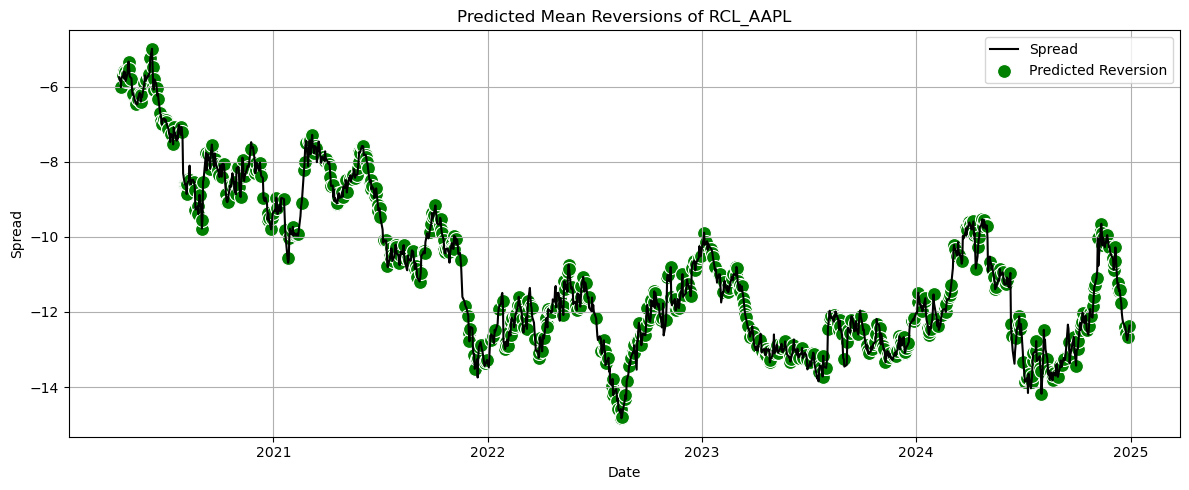

Confusion Matrix:
[[254 285]
 [281 368]]
F1 Score: 0.5653

Training model for pair: MSI_NVDA
Epoch 1/50 - Loss: 0.6569
Epoch 2/50 - Loss: 0.5731
Epoch 3/50 - Loss: 0.5235
Epoch 4/50 - Loss: 0.5066
Epoch 5/50 - Loss: 0.4972
Epoch 6/50 - Loss: 0.4787
Epoch 7/50 - Loss: 0.4577
Epoch 8/50 - Loss: 0.4382
Epoch 9/50 - Loss: 0.4179
Epoch 10/50 - Loss: 0.3986
Epoch 11/50 - Loss: 0.3843
Epoch 12/50 - Loss: 0.3701
Epoch 13/50 - Loss: 0.3549
Epoch 14/50 - Loss: 0.3515
Epoch 15/50 - Loss: 0.3358
Epoch 16/50 - Loss: 0.3385
Epoch 17/50 - Loss: 0.3248
Epoch 18/50 - Loss: 0.3175
Epoch 19/50 - Loss: 0.3255
Epoch 20/50 - Loss: 0.3208
Epoch 21/50 - Loss: 0.3378
Epoch 22/50 - Loss: 0.3177
Epoch 23/50 - Loss: 0.3064
Epoch 24/50 - Loss: 0.3180
Epoch 25/50 - Loss: 0.3141
Epoch 26/50 - Loss: 0.2957
Epoch 27/50 - Loss: 0.2961
Epoch 28/50 - Loss: 0.2952
Epoch 29/50 - Loss: 0.2878
Epoch 30/50 - Loss: 0.2902
Epoch 31/50 - Loss: 0.2849
Epoch 32/50 - Loss: 0.2766
Epoch 33/50 - Loss: 0.2794
Epoch 34/50 - Loss: 0.281

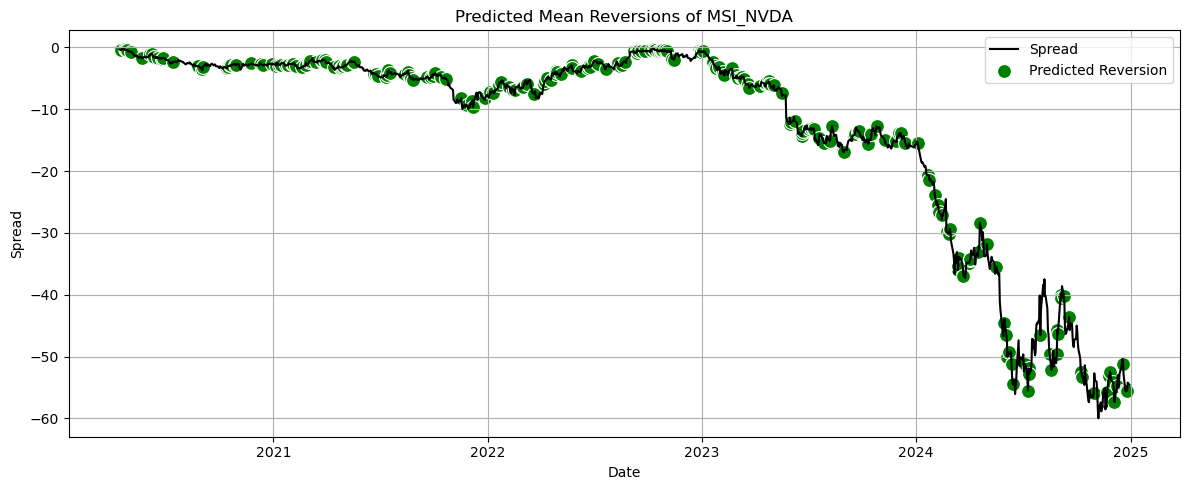

Confusion Matrix:
[[464  14]
 [480 230]]
F1 Score: 0.4822

Training model for pair: MSI_MSFT
Epoch 1/50 - Loss: 0.6645
Epoch 2/50 - Loss: 0.5724
Epoch 3/50 - Loss: 0.5267
Epoch 4/50 - Loss: 0.5321
Epoch 5/50 - Loss: 0.4876
Epoch 6/50 - Loss: 0.4668
Epoch 7/50 - Loss: 0.4637
Epoch 8/50 - Loss: 0.4602
Epoch 9/50 - Loss: 0.4333
Epoch 10/50 - Loss: 0.4328
Epoch 11/50 - Loss: 0.4197
Epoch 12/50 - Loss: 0.3980
Epoch 13/50 - Loss: 0.3962
Epoch 14/50 - Loss: 0.3879
Epoch 15/50 - Loss: 0.3721
Epoch 16/50 - Loss: 0.3822
Epoch 17/50 - Loss: 0.3655
Epoch 18/50 - Loss: 0.3777
Epoch 19/50 - Loss: 0.3735
Epoch 20/50 - Loss: 0.3582
Epoch 21/50 - Loss: 0.3645
Epoch 22/50 - Loss: 0.3665
Epoch 23/50 - Loss: 0.3706
Epoch 24/50 - Loss: 0.3556
Epoch 25/50 - Loss: 0.3449
Epoch 26/50 - Loss: 0.3511
Epoch 27/50 - Loss: 0.3363
Epoch 28/50 - Loss: 0.3458
Epoch 29/50 - Loss: 0.3332
Epoch 30/50 - Loss: 0.3223
Epoch 31/50 - Loss: 0.3389
Epoch 32/50 - Loss: 0.3189
Epoch 33/50 - Loss: 0.3161
Epoch 34/50 - Loss: 0.319

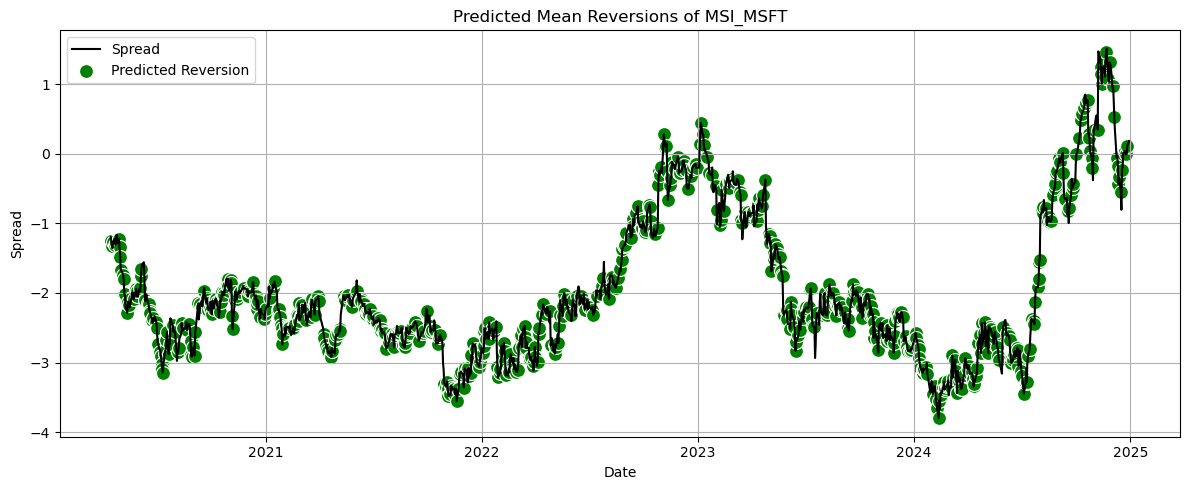

Confusion Matrix:
[[340 228]
 [121 499]]
F1 Score: 0.7409

Training model for pair: MSI_AAPL
Epoch 1/50 - Loss: 0.6606
Epoch 2/50 - Loss: 0.5571
Epoch 3/50 - Loss: 0.4995
Epoch 4/50 - Loss: 0.4747
Epoch 5/50 - Loss: 0.4665
Epoch 6/50 - Loss: 0.4436
Epoch 7/50 - Loss: 0.4279
Epoch 8/50 - Loss: 0.4063
Epoch 9/50 - Loss: 0.3884
Epoch 10/50 - Loss: 0.3780
Epoch 11/50 - Loss: 0.3677
Epoch 12/50 - Loss: 0.3553
Epoch 13/50 - Loss: 0.3503
Epoch 14/50 - Loss: 0.3379
Epoch 15/50 - Loss: 0.3312
Epoch 16/50 - Loss: 0.3370
Epoch 17/50 - Loss: 0.3303
Epoch 18/50 - Loss: 0.3204
Epoch 19/50 - Loss: 0.3278
Epoch 20/50 - Loss: 0.3274
Epoch 21/50 - Loss: 0.3183
Epoch 22/50 - Loss: 0.3001
Epoch 23/50 - Loss: 0.2974
Epoch 24/50 - Loss: 0.3026
Epoch 25/50 - Loss: 0.2925
Epoch 26/50 - Loss: 0.2858
Epoch 27/50 - Loss: 0.2842
Epoch 28/50 - Loss: 0.2738
Epoch 29/50 - Loss: 0.2739
Epoch 30/50 - Loss: 0.2814
Epoch 31/50 - Loss: 0.2769
Epoch 32/50 - Loss: 0.2658
Epoch 33/50 - Loss: 0.2751
Epoch 34/50 - Loss: 0.276

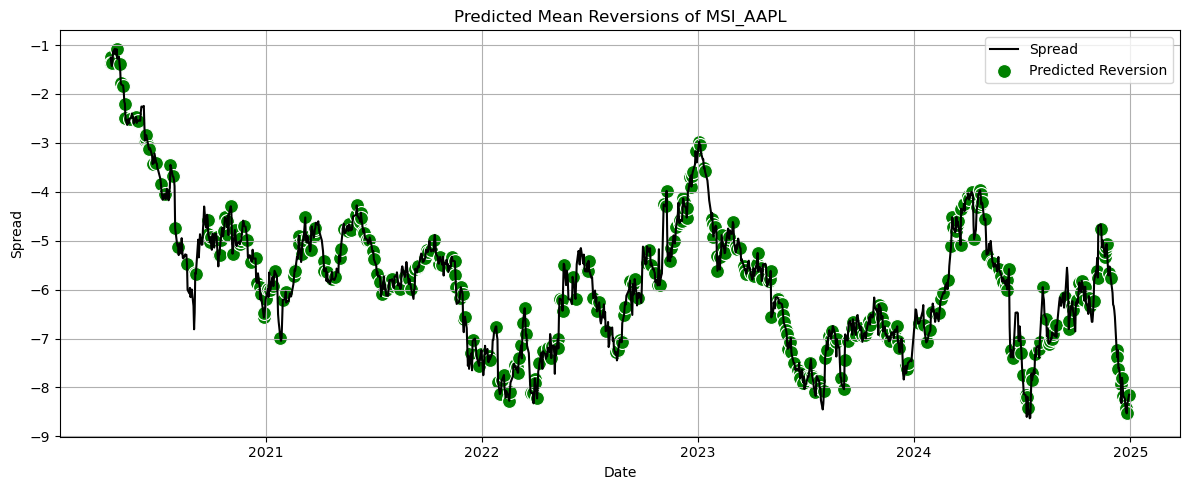

Confusion Matrix:
[[431  58]
 [327 372]]
F1 Score: 0.6590
{'NEM_NVDA': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], shape=(1188, 1), dtype=float32), 'y_pred': array([0.6733671 , 0.9162116 , 0.7283839 , ..., 0.4172957 , 0.02592812,
       0.61098325], shape=(1188,), dtype=float32)}, 'NEM_MSFT': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], shape=(1188, 1), dtype=float32), 'y_pred': array([0.10917077, 0.23224843, 0.18161438, ..., 0.95682347, 0.05770344,
       0.99821717], shape=(1188,), dtype=float32)}, 'NEM_AAPL': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch

In [13]:
results = {}

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 50,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [14]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [15]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [16]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [17]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 10,
    entry_threshold = 1,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob > 0.5 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [ ]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.7).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)

    plt.title("LSTM Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(combined_equity['Total'])

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # show last 10 rows for this pair
        print("-" * 40)

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_40478/922467761.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')


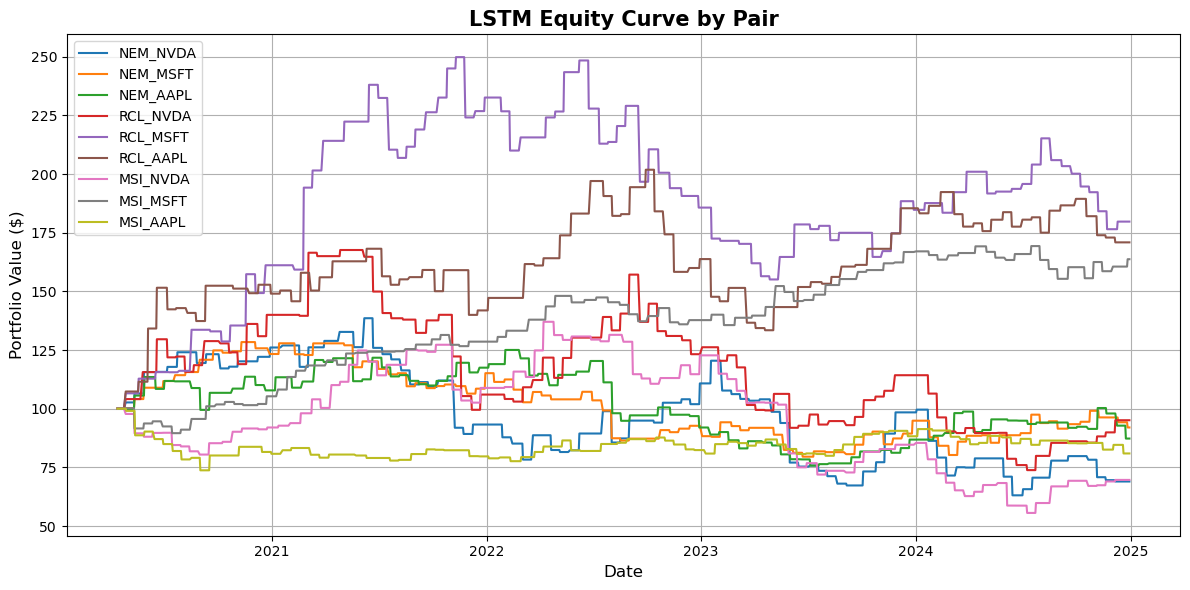


Final Portfolio Value: $1,008.24

Trade Summary:
  NEM_NVDA: 84 trades | Total PnL: $-31.03 | Avg PnL: $-0.37
  NEM_MSFT: 89 trades | Total PnL: $-8.00 | Avg PnL: $-0.09
  NEM_AAPL: 87 trades | Total PnL: $-12.73 | Avg PnL: $-0.15
  RCL_NVDA: 84 trades | Total PnL: $-4.92 | Avg PnL: $-0.06
  RCL_MSFT: 83 trades | Total PnL: $79.74 | Avg PnL: $0.96
  RCL_AAPL: 82 trades | Total PnL: $70.90 | Avg PnL: $0.86
  MSI_NVDA: 90 trades | Total PnL: $-30.36 | Avg PnL: $-0.34
  MSI_MSFT: 86 trades | Total PnL: $63.72 | Avg PnL: $0.74
  MSI_AAPL: 86 trades | Total PnL: $-19.08 | Avg PnL: $-0.22

Year-End Portfolio Values:
              NEM_NVDA    NEM_MSFT    NEM_AAPL    RCL_NVDA    RCL_MSFT  \
Date                                                                     
2020-12-31  126.087369  123.313610  107.808833  140.000916  161.142944   
2021-12-31   93.248844  115.141672  117.485879  106.018712  232.627951   
2022-12-31  110.781110   92.712383   91.985486  123.226351  185.717447   
2023-12-31 

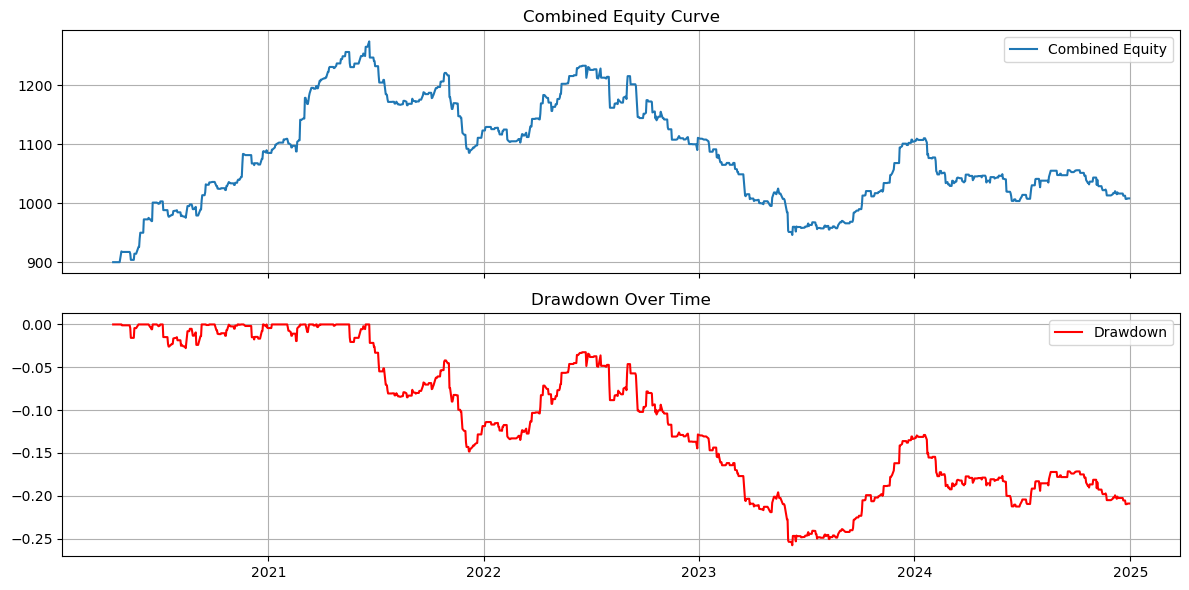

Pair: NEM_NVDA
Date
2024-12-16    68.967473
2024-12-17    68.967473
2024-12-18    68.967473
2024-12-19    68.967473
2024-12-20    68.967473
2024-12-23    68.967473
2024-12-24    68.967473
2024-12-26    68.967473
2024-12-27    68.967473
2024-12-30    68.967473
Name: NEM_NVDA, dtype: float64
----------------------------------------
Pair: NEM_MSFT
Date
2024-12-16    94.219031
2024-12-17    94.219031
2024-12-18    94.219031
2024-12-19    94.219031
2024-12-20    94.219031
2024-12-23    94.219031
2024-12-24    94.219031
2024-12-26    94.219031
2024-12-27    91.996461
2024-12-30    91.996461
Name: NEM_MSFT, dtype: float64
----------------------------------------
Pair: NEM_AAPL
Date
2024-12-16    92.779577
2024-12-17    92.779577
2024-12-18    92.779577
2024-12-19    92.779577
2024-12-20    92.779577
2024-12-23    92.779577
2024-12-24    87.271232
2024-12-26    87.271232
2024-12-27    87.271232
2024-12-30    87.271232
Name: NEM_AAPL, dtype: float64
----------------------------------------
Pair

OSError: Cannot save file into a non-existent directory: 'equity_curves'

In [19]:
run_simulation(results, X_test_dict, testing_data)